## Techniques Used
<ul>
  <li><p>Raditional CNN-RNN model</p></li>
  <li><p>Attention model</p></li>
  <li><p>Text and Image preprocessing</p></li>
  <li><p>Data Visualization using wordcloud</p></li>
  <li><p>Model training and model evaluation (INCEPTIONV3)</p></li>
  <li><p>Greedy search vs Beam search and BLUE Score</p></li>
  
</ul>

In [ ]:
!pip install tensorflow

In [ ]:
#Import all the required libraries


!pip install wordcloud
!pip install gtts
!pip install playsound

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import tensorflow as tf
import keras
from keras.preprocessing.image import load_img
import string
import time
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras import Input
from PIL import Image
#used for creating Progress Meters or Progress Bars
from tqdm import tqdm


In [ ]:
import glob
from gtts import gTTS
from playsound import playsound
from IPython import display
import collections
import wordcloud
from wordcloud import WordCloud, STOPWORDS


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


 <h2> Data Understanding and Visualization
</h2><ul>
  <li><p>Import the dataset and read image and captions into two seperate variables</p>
        </li>
  <li><p>Visualise both the images & text present in the dataset</p></li>
  <li>Visualise the top 30 occuring words in the captions
</li>
    li>Visualise the top 30 occuring words in the captions
</li>
<li>Create a list which contains all the captions & path</li>
</ul>





In [ ]:
images="/content/drive/MyDrive/DM annovative/Images"
all_imgs = glob.glob(images + '/*.jpg',recursive=True)
print("The total images present in the dataset: {}".format(len(all_imgs)))

The total images present in the dataset: 8091


<ipython-input-6-769562a02e30>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ax.imshow(imageio.imread(image), cmap=None)


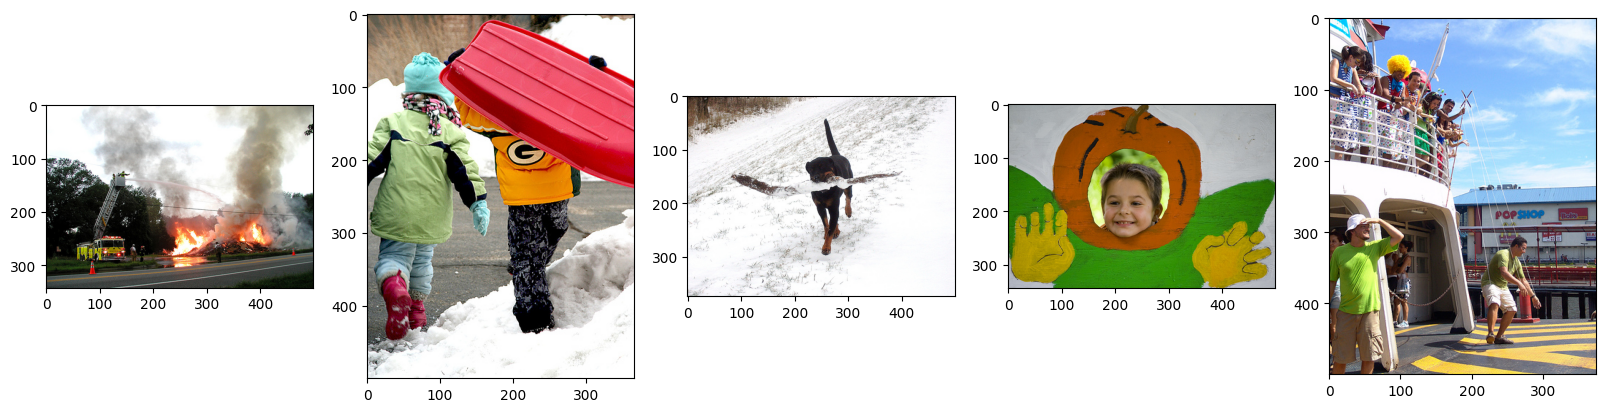

In [ ]:
import imageio
#Visualising first 5 images :
Display_Images = all_imgs[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(20)
for ax, image in zip(axes, Display_Images):
  ax.imshow(imageio.imread(image), cmap=None)


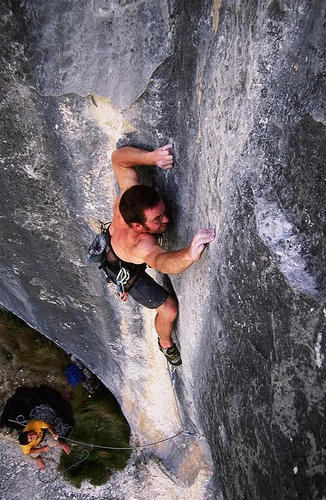

In [ ]:
import random
Image.open(all_imgs[random.randrange(40, 60, 3)])# view a random image
import random
Image.open(all_imgs[random.randrange(40, 60, 3)])

In [ ]:
text_file = '/content/drive/MyDrive/DM annovative/captions.txt'
def load_doc(filename):
    open_file = open(text_file, 'r', encoding='latin-1' )
    text = open_file.read()
    open_file.close()
    return text
doc = load_doc(text_file)
print(doc[:300])

image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing


In [ ]:
img_path = '/content/drive/MyDrive/DM annovative/Images/'

all_img_id = []
all_img_vector = []
annotations = []

with open('/content/drive/MyDrive/DM annovative/captions.txt' , 'r') as fo:
  next(fo)
  for line in fo :
    split_arr = line.split(',')
    all_img_id.append(split_arr[0])
    annotations.append(split_arr[1].rstrip('\n.')) #removing out the \n.
    all_img_vector.append(img_path+split_arr[0])

df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions'])

df

ID  \
0      1000268201_693b08cb0e.jpg   
1      1000268201_693b08cb0e.jpg   
2      1000268201_693b08cb0e.jpg   
3      1000268201_693b08cb0e.jpg   
4      1000268201_693b08cb0e.jpg   
...                          ...   
40450   997722733_0cb5439472.jpg   
40451   997722733_0cb5439472.jpg   
40452   997722733_0cb5439472.jpg   
40453   997722733_0cb5439472.jpg   
40454   997722733_0cb5439472.jpg   

                                                    Path  \
0      /content/drive/MyDrive/DM annovative/Images/10...   
1      /content/drive/MyDrive/DM annovative/Images/10...   
2      /content/drive/MyDrive/DM annovative/Images/10...   
3      /content/drive/MyDrive/DM annovative/Images/10...   
4      /content/drive/MyDrive/DM annovative/Images/10...   
...                                                  ...   
40450  /content/drive/MyDrive/DM annovative/Images/99...   
40451  /content/drive/MyDrive/DM annovative/Images/99...   
40452  /content/drive/MyDrive/DM annovative/Images/99...   
40453  /content/drive/MyDrive/DM annovative/Images/99...   
40454  /content/drive/MyDrive/DM annovative/Images/99...   

                                                Captions  
0      A child in a pink dress is climbing up a set o...  
1                   A girl going into a wooden building   
2        A little girl climbing into a wooden playhouse   
3      A little girl climbing the stairs to her playh...  
4      A little girl in a pink dress going into a woo...  
...                                                  ...  
40450           A man in a pink shirt climbs a rock face  
40451            A man is rock climbing high in the air   
40452  A person in a red shirt climbing up a rock fac...  
40453                     A rock climber in a red shirt   
40454  A rock climber practices on a rock climbing wall   

[40455 rows x 3 columns]

In [ ]:
#check total captions and images present in dataset
print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_imgs)))

Total captions present in the dataset: 40455
Total images present in the dataset: 8091


In [ ]:
#Create the vocabulary & the counter for the captions
vocabulary = [word.lower() for line in annotations for word in line.split()]
val_count = Counter(vocabulary)
val_count

Counter({'a': 60196,
         'child': 1507,
         'in': 18174,
         'pink': 702,
         'dress': 332,
         'is': 9069,
         'climbing': 490,
         'up': 1215,
         'set': 105,
         'of': 6495,
         'stairs': 109,
         'an': 2325,
         'entry': 1,
         'way': 48,
         'girl': 3277,
         'going': 145,
         'into': 1046,
         'wooden': 278,
         'building': 485,
         'little': 1736,
         'playhouse': 6,
         'the': 17507,
         'to': 3005,
         'her': 1102,
         'cabin': 4,
         'black': 3620,
         'dog': 7948,
         'and': 8057,
         'spotted': 36,
         'are': 3365,
         'fighting': 130,
         'tri-colored': 12,
         'playing': 1954,
         'with': 7304,
         'each': 399,
         'other': 667,
         'on': 10357,
         'road': 380,
         'white': 3706,
         'brown': 2457,
         'spots': 28,
         'staring': 57,
         'at': 2810,
         'stree

a :  60196
in :  18174
the :  17507
on :  10357
is :  9069
and :  8057
dog :  7948
with :  7304
man :  7137
of :  6495
two :  5132
white :  3706
black :  3620
boy :  3514
are :  3365
woman :  3304
girl :  3277
to :  3005
wearing :  2916
people :  2811
at :  2810
water :  2676
young :  2587
red :  2553
brown :  2457
an :  2325
his :  2255
blue :  2125
dogs :  2095
running :  1996


Text(0, 0.5, 'Count')

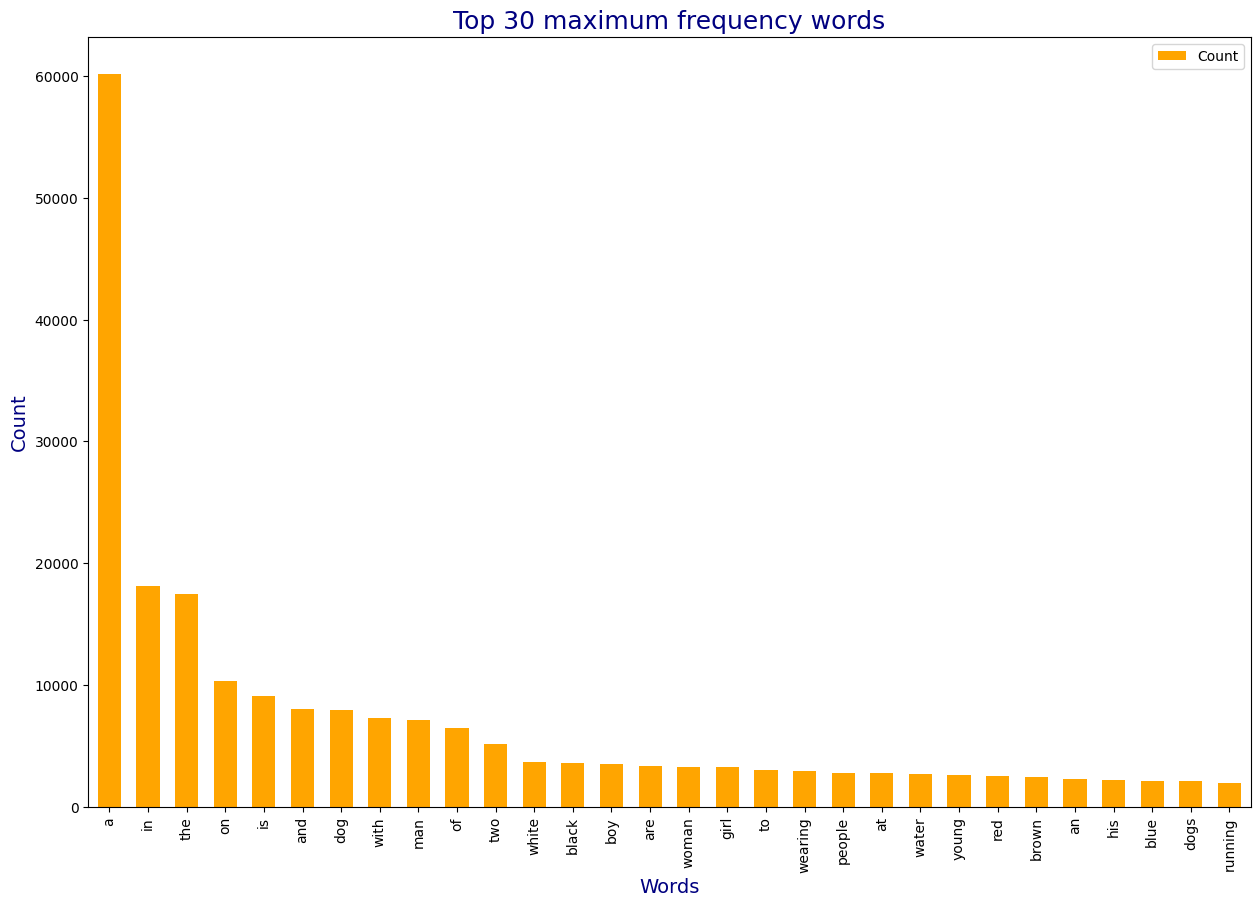

In [ ]:
#Visualise the top 30 occuring words in the captions
for word, count in val_count.most_common(30):
  print(word, ": ", count)

lst = val_count.most_common(30)
most_common_words_df = pd.DataFrame(lst, columns = ['Word', 'Count'])
most_common_words_df.plot.bar(x='Word', y='Count', width=0.6, color='orange', figsize=(15, 10))
plt.title("Top 30 maximum frequency words", fontsize = 18, color= 'navy')
plt.xlabel("Words", fontsize = 14, color= 'navy')
plt.ylabel("Count", fontsize = 14, color= 'navy')


### Clearly STOPWORDS form a clear majority

**Stop words are a set of commonly used words in a language.**

    Examples of stop words in English are “a”, “the”, “is”, “are” and etc.
    
*Stop words are commonly used in **Text Mining and Natural Language Processing (NLP)** to eliminate words that are so commonly used that they carry very little useful information.*

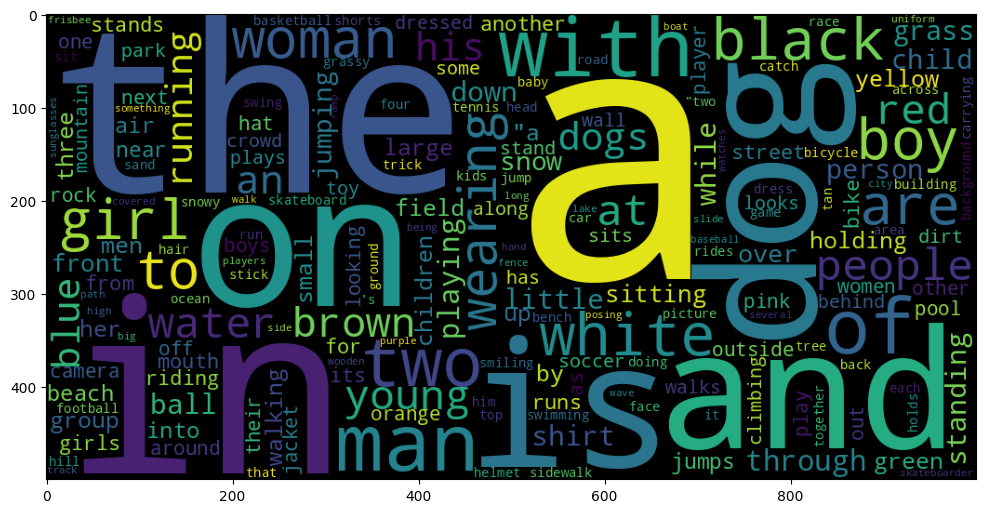

In [ ]:
wordcloud = WordCloud(width = 1000, height = 500).generate_from_frequencies(val_count)
plt.figure(figsize = (12, 12))
plt.imshow(wordcloud)

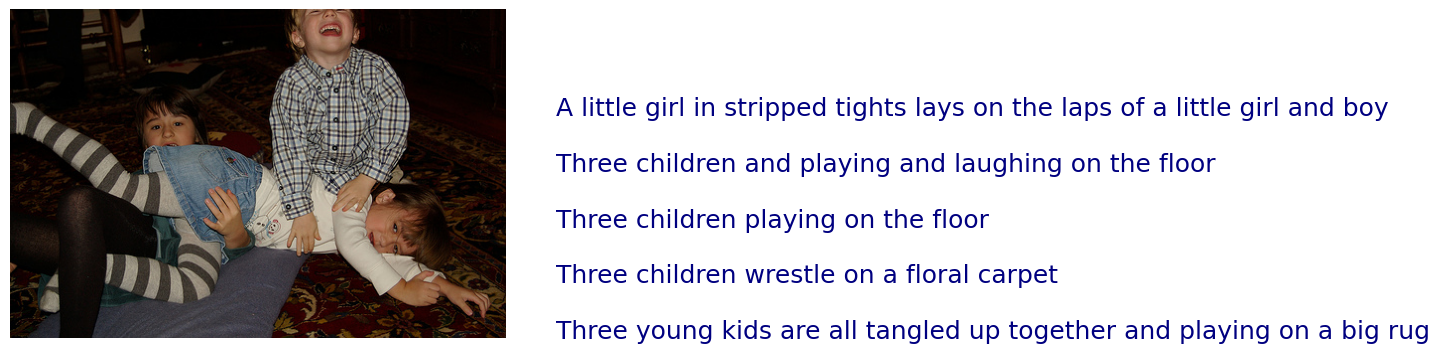

In [ ]:
def caption_with_img_plot(image_id, frame) :
  capt = ("\n" *2).join(frame[frame['ID'] == image_id].Captions.to_list())
  fig, ax = plt.subplots()
  ax.set_axis_off()
  idx = df.ID.to_list().index(image_id)
  im =  Image.open(df.Path.iloc[idx])
  w, h = im.size[0], im.size[-1]
  ax.imshow(im)
  ax.text(w+50, h, capt, fontsize = 18, color = 'navy')
caption_with_img_plot(df.ID.iloc[4465], df)


 <h2> Clean Data
</h2><ul>
<li><p> Remove punctuations</p></li>
<li><p>Convert captions to lowercase</p></li>
<li>Visualise the top 30 occuring words in the captions</li>
<li>Visualise the top 30 occuring words in the captions</li>
<li>Create a list which contains all the captions & path</li>
</ul>





In [ ]:
#data cleaning
rem_punct = str.maketrans('', '', string.punctuation)
for r in range(len(annotations)) :
  line = annotations[r]
  line = line.split()

  # converting to lowercase
  line = [word.lower() for word in line]

  # remove punctuation from each caption and hanging letters
  line = [word.translate(rem_punct) for word in line]
  line = [word for word in line if len(word) > 1]

  # remove numeric values
  line = [word for word in line if word.isalpha()]

  annotations[r] = ' '.join(line)


In [ ]:
#add the <start> & <end> token to all those captions as well
annotations = ['<start>' + ' ' + line + ' ' + '<end>' for line in annotations]

#Create a list which contains all the path to the images
all_img_path = all_img_vector

In [ ]:
##list contatining captions for an image
annotations[5:10]

['<start> black dog and spotted dog are fighting <end>',
 '<start> black dog and tricolored dog playing with each other on the road <end>',
 '<start> black dog and white dog with brown spots are staring at each other in the street <end>',
 '<start> two dogs of different breeds looking at each other on the road <end>',
 '<start> two dogs on pavement moving toward each other <end>']

 <h2> Data Preprocessing</h2>
 <ul>
  <li><p>Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters./p>
        </li>
  <li><p>This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.</p></li>
    <li><p>Replace all other words with the unknown token "UNK"</p>
</li>
    <li><p>Create word-to-index and index-to-word mappings.</p>
</li>
    <li><p>Pad all sequences to be the same length as the longest one</p></li>
</ul>




In [ ]:
# Creating the tokenizer
top_word_cnt = 5000
tokenizer = Tokenizer(num_words = top_word_cnt+1, filters= '!"#$%^&*()_+.,:;-?/~`{}[]|\=@ ',
                      lower = True, char_level = False,
                      oov_token = 'UNK')

In [ ]:
# Creating word-to-index and index-to-word mappings.

tokenizer.fit_on_texts(annotations)
#transform each text into a sequence of integers
train_seqs = tokenizer.texts_to_sequences(annotations)

In [ ]:
# We add PAD token for zero
tokenizer.word_index['PAD'] = 0
tokenizer.index_word[0] = 'PAD'

In [ ]:
print(tokenizer.oov_token)
print(tokenizer.index_word[0])

UNK
PAD


In [ ]:
tokenizer.index_word

{1: 'UNK',
 2: '<start>',
 3: '<end>',
 4: 'in',
 5: 'the',
 6: 'on',
 7: 'is',
 8: 'and',
 9: 'dog',
 10: 'with',
 11: 'man',
 12: 'of',
 13: 'two',
 14: 'white',
 15: 'black',
 16: 'boy',
 17: 'are',
 18: 'woman',
 19: 'girl',
 20: 'to',
 21: 'wearing',
 22: 'people',
 23: 'at',
 24: 'water',
 25: 'young',
 26: 'red',
 27: 'brown',
 28: 'an',
 29: 'his',
 30: 'blue',
 31: 'dogs',
 32: 'running',
 33: 'through',
 34: 'playing',
 35: 'while',
 36: 'down',
 37: 'little',
 38: 'shirt',
 39: 'standing',
 40: 'ball',
 41: 'grass',
 42: 'person',
 43: 'child',
 44: 'snow',
 45: 'jumping',
 46: 'over',
 47: 'three',
 48: 'front',
 49: 'sitting',
 50: 'small',
 51: 'field',
 52: 'up',
 53: 'holding',
 54: 'large',
 55: 'group',
 56: 'by',
 57: 'green',
 58: 'yellow',
 59: 'children',
 60: 'walking',
 61: 'men',
 62: 'her',
 63: 'into',
 64: 'beach',
 65: 'air',
 66: 'near',
 67: 'jumps',
 68: 'mouth',
 69: 'street',
 70: 'runs',
 71: 'for',
 72: 'another',
 73: 'riding',
 74: 'from',
 75: 'it

In [ ]:
# Creating a word count for our tokenizer to visualize the Top 30 occuring words after text processing

tokenizer_top_words = [word for line in annotations for word in line.split() ]

#tokenizer_top_words_count
tokenizer_top_words_count = collections.Counter(tokenizer_top_words)


<start> :  40455
<end> :  40455
in :  18182
the :  17676
on :  10367
is :  9069
and :  8057
dog :  7956
with :  7308
man :  7164
of :  6496
two :  5546
white :  3710
black :  3627
boy :  3534
are :  3365
woman :  3320
girl :  3284
to :  3005
wearing :  2917
people :  2837
at :  2819
water :  2676
young :  2610
red :  2553
brown :  2471
an :  2358
his :  2255
blue :  2125
dogs :  2097


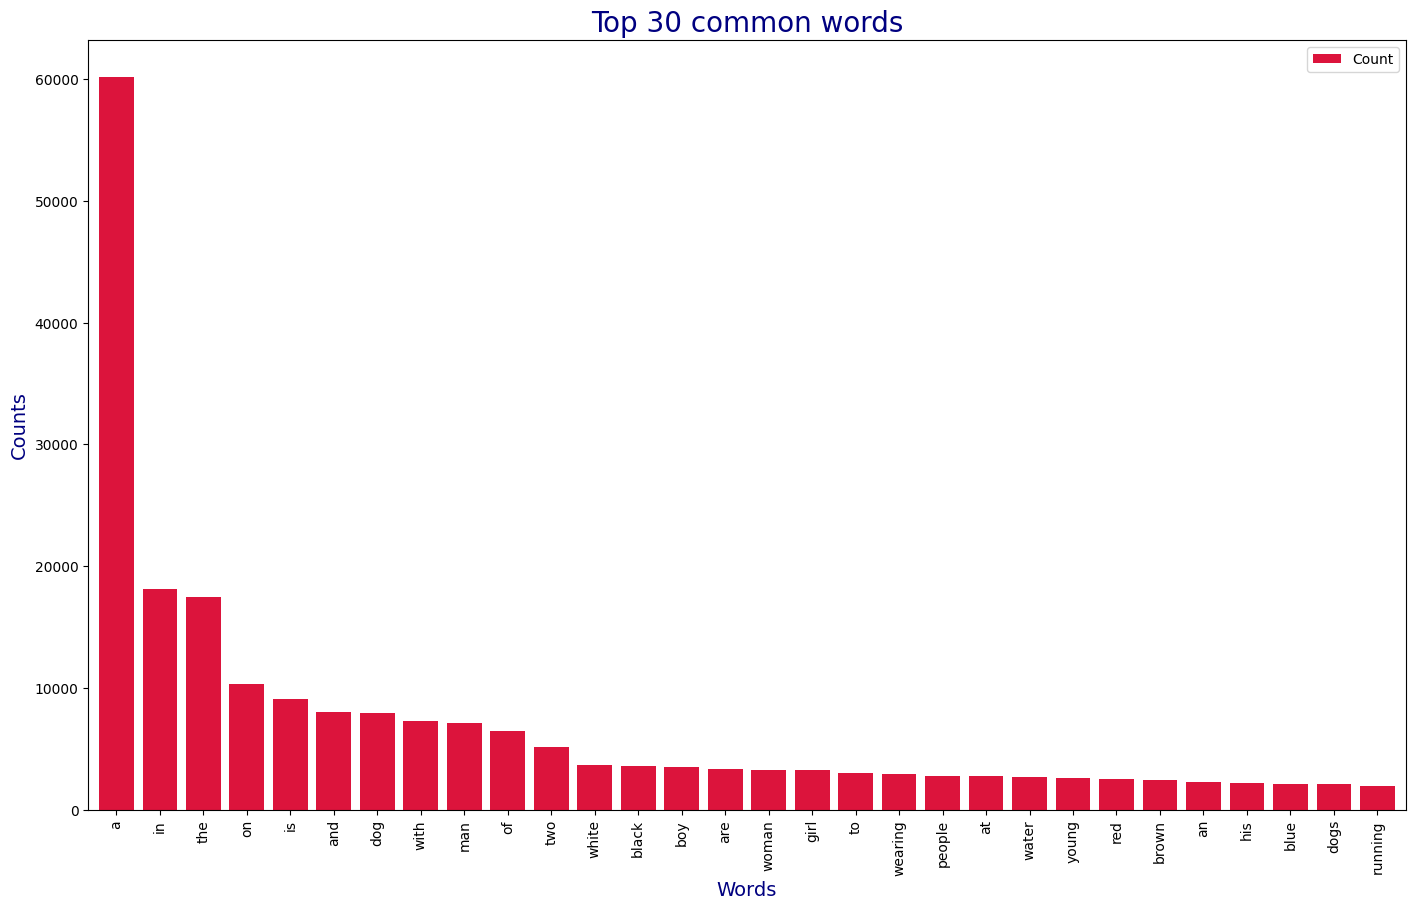

In [ ]:
for word, count in tokenizer_top_words_count.most_common(30) :
  print(word, ": ", count)

tokens = tokenizer_top_words_count.most_common(30)
most_com_words_df = pd.DataFrame(tokens, columns = ['Word', 'Count'])

#plot 30 most common words
most_common_words_df.plot.bar(x = 'Word', y= 'Count', width=0.8, color = 'crimson', figsize = (17, 10))
plt.title('Top 30 common words', fontsize =20, color= 'navy')
plt.xlabel('Words', fontsize =14, color= 'navy')
plt.ylabel('Counts', fontsize =14, color= 'navy')
plt.grid(False)  # Changed parameter to False
plt.show()

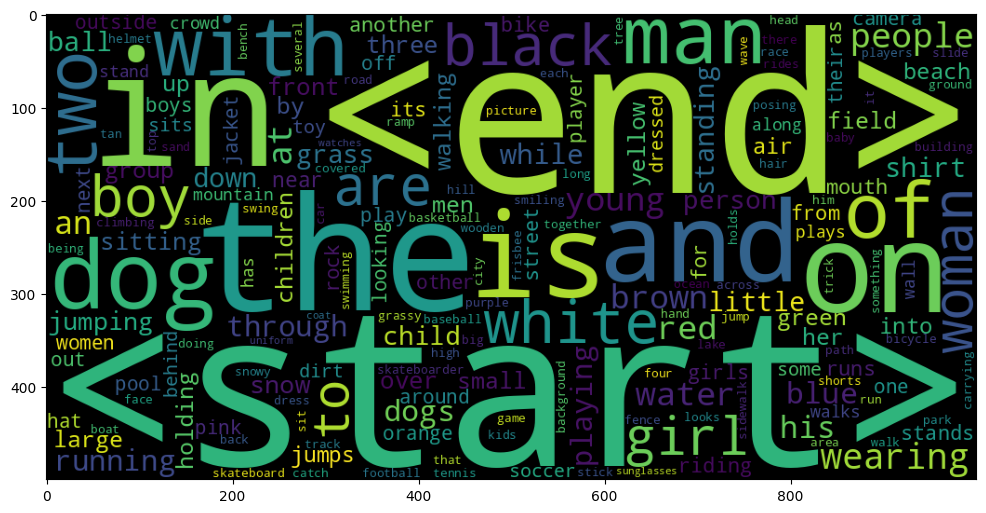

In [ ]:
wordcloud_token = WordCloud(width = 1000, height = 500).generate_from_frequencies(tokenizer_top_words_count)
plt.figure(figsize = (12, 8))
plt.imshow(wordcloud_token)
plt.grid(False)  # Changed parameter to False
plt.show()

In [ ]:
# Pad each vector to the max_length of the captions  store it to a vairable

train_seqs_len = [len(seq) for seq in train_seqs]

longest_word_length = max(train_seqs_len)

cap_vector= tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding= 'post', maxlen = longest_word_length,
                                                          dtype='int32', value=0)
print("The shape of Caption vector is :" + str(cap_vector.shape))

The shape of Caption vector is :(40455, 31)


In [ ]:
# creating list to store preprocessed images and setting up the Image Shape

preprocessed_image = []
IMAGE_SHAPE = (299, 299)

In [ ]:
#checking image format

tf.keras.backend.image_data_format()


'channels_last'

In [ ]:
for img in all_imgs[0:5] :
    img = tf.io.read_file(img, name=None)
    img = tf.image.decode_jpeg(img, channels=0)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    preprocessed_image.append(img)


Shape after resize :  (299, 299, 3)
Shape after resize :  (299, 299, 3)
Shape after resize :  (299, 299, 3)
Shape after resize :  (299, 299, 3)
Shape after resize :  (299, 299, 3)


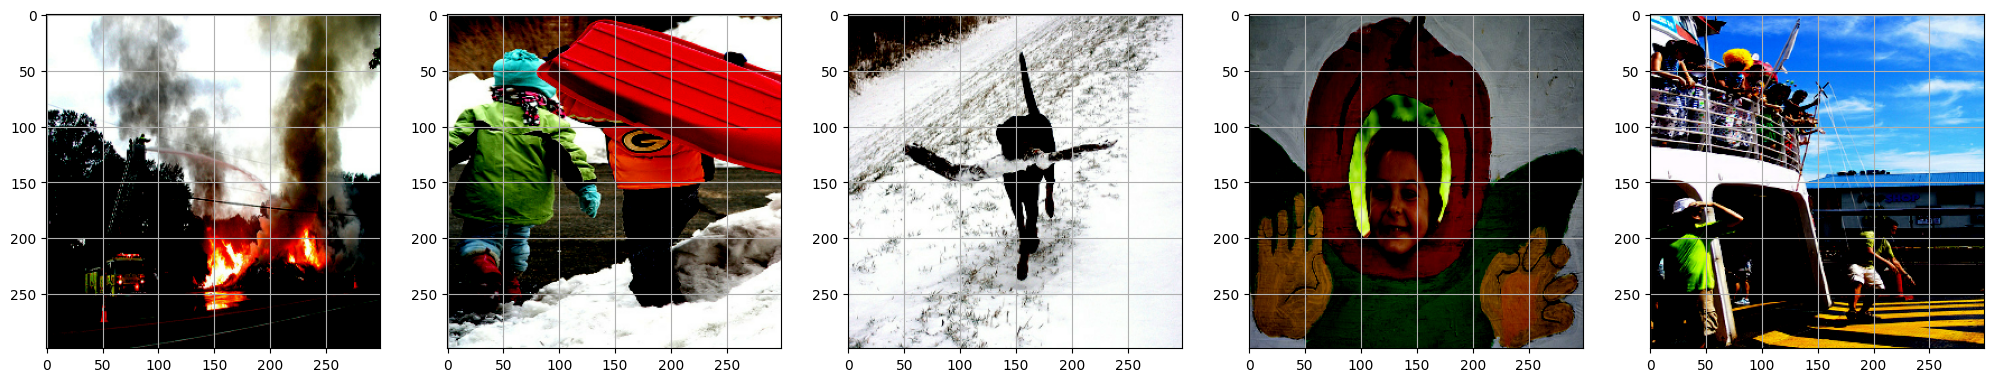

In [ ]:
# checking first five images post preprocessing
Display_Images = preprocessed_image[0:5]
figure, axes = plt.subplots(1,5)
figure.set_figwidth(25)
for ax, image in zip(axes, Display_Images) :
  print('Shape after resize : ', image.shape)
  ax.imshow(image)
  ax.grid('off')


 <h2>  Dataset creation
</h2><ul>
  <li><p>Create a function which maps the image path to their feature</p>
        </li>
  <li><p>Create a builder function to create train & test dataset & apply the function created earlier to transform the dataset</p></li>
  <li>Apply train_test_split on both image path & captions to create the train & test list. Create the train-test spliit using 80-20 ratio & random state = 42
</li>
    <li>Make sure you have done Shuffle and batch while building the dataset</li>
<li>
The shape of each image in the dataset after building should be (batch_size, 8*8, 2048)
</li>

</ul>






In [ ]:
def load_images(image_path) :
  img = tf.io.read_file(image_path, name = None)
  img = tf.image.decode_jpeg(img, channels=0)
  img = tf.image.resize(img, IMAGE_SHAPE)
  img = tf.keras.applications.inception_v3.preprocess_input(img)
  return img, image_path

In [ ]:
all_img_vector

['/content/drive/MyDrive/DM annovative/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/DM annovative/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/DM annovative/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/DM annovative/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/DM annovative/Images/1000268201_693b08cb0e.jpg',
 '/content/drive/MyDrive/DM annovative/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/DM annovative/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/DM annovative/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/DM annovative/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/DM annovative/Images/1001773457_577c3a7d70.jpg',
 '/content/drive/MyDrive/DM annovative/Images/1002674143_1b742ab4b8.jpg',
 '/content/drive/MyDrive/DM annovative/Images/1002674143_1b742ab4b8.jpg',
 '/content/drive/MyDrive/DM annovative/Images/1002674143_1b742ab4b8.jpg',
 '/content/drive/MyDrive/DM annovative

In [ ]:
# Map each image full path to the function, in order to preprocess the image
training_list = sorted(set(all_img_vector))
New_Img = tf.data.Dataset.from_tensor_slices(training_list)
New_Img = New_Img.map(load_images, num_parallel_calls = tf.data.experimental.AUTOTUNE)
New_Img = New_Img.batch(64, drop_remainder=False)


In [ ]:
#Ratio = 80:20 and we will set random state = 42
path_train, path_test, caption_train, caption_test = train_test_split(all_img_vector, cap_vector, test_size = 0.2, random_state = 42)

In [ ]:
print("Training data for images: " + str(len(path_train)))
print("Testing data for images: " + str(len(path_test)))
print("Training data for Captions: " + str(len(caption_train)))
print("Testing data for Captions: " + str(len(caption_test)))

Training data for images: 32364
Testing data for images: 8091
Training data for Captions: 32364
Testing data for Captions: 8091


 <h2> Load the pretrained Imagenet weights of Inception net V3
</h2><ul>
  <li><p>To save the memory(RAM) from getting exhausted, extract the features of the images using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.</p>
        </li>
  <li><p>The shape of the output of this layer is 8x8x2048.</p></li>
  <li>Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)
</li>
   

    

In [ ]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.compat.v1.keras.Model(new_input, hidden_layer)

In [ ]:
# Once the features are created, you need to reshape them such that feature shape is in order of (batch_size, 8*8, 2048)
image_features_extract_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, None, None, 32)       0         ['batch_normalization[0][0

In [ ]:
# extract features from each image in the dataset
img_features = {}
for image, image_path in tqdm(New_Img) :
  batch_features = image_features_extract_model(image)
  #squeeze out the features in a batch
  batch_features_flattened = tf.reshape(batch_features, (batch_features.shape[0], -1, batch_features.shape[3]))
  for batch_feat, path in zip(batch_features_flattened, image_path) :
    feature_path = path.numpy().decode('utf-8')
    img_features[feature_path] = batch_feat.numpy()

100%|██████████| 127/127 [03:13<00:00,  1.52s/it]


In [ ]:
batch_features

<tf.Tensor: shape=(27, 8, 8, 2048), dtype=float32, numpy=
array([[[[0.00000000e+00, 7.74677992e-02, 0.00000000e+00, ...,
          2.31835991e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          1.07786879e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 1.94032133e-01, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 1.85754240e-01],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          9.42655802e-02, 0.00000000e+00, 5.05788982e-01],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 4.23006088e-01, 1.34447515e-02, ...,
          2.33670264e-01, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         

In [ ]:
batch_features_flattened

<tf.Tensor: shape=(27, 64, 2048), dtype=float32, numpy=
array([[[0.0000000e+00, 7.7467799e-02, 0.0000000e+00, ...,
         2.3183599e-01, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         1.0778688e-01, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 1.9403213e-01, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 1.8575424e-01],
        ...,
        [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         0.0000000e+00, 1.6569376e+00, 0.0000000e+00],
        [0.0000000e+00, 4.0261242e-01, 0.0000000e+00, ...,
         0.0000000e+00, 3.1792119e-01, 0.0000000e+00],
        [0.0000000e+00, 2.5347552e+00, 0.0000000e+00, ...,
         0.0000000e+00, 0.0000000e+00, 0.0000000e+00]],

       [[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ...,
         1.2506019e+00, 0.0000000e+00, 0.0000000e+00],
        [0.0000000e+00, 0.0000000e+00, 7.8494191e-02, ...,
         1.2064203e+00, 0.0000000e+00, 0.0000000e+00],
        [0.000000

In [ ]:
batch_feat.shape

TensorShape([64, 2048])

In [ ]:
#view top five items of img_features dict
import more_itertools
top_5 = more_itertools.take(5, img_features.items())
top_5

[('/content/drive/MyDrive/DM annovative/Images/1000268201_693b08cb0e.jpg',
  array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
          0.16987066],
         [0.        , 0.        , 1.0105915 , ..., 0.        , 0.        ,
          0.06111826],
         ...,
         [0.        , 0.        , 2.0380409 , ..., 1.2029686 , 0.        ,
          1.9924107 ],
         [0.        , 0.        , 0.9046898 , ..., 0.        , 0.        ,
          0.        ],
         [0.        , 1.2527283 , 0.        , ..., 0.        , 0.        ,
          0.        ]], dtype=float32)),
 ('/content/drive/MyDrive/DM annovative/Images/1001773457_577c3a7d70.jpg',
  array([[0.        , 0.6636832 , 0.46285722, ..., 0.        , 0.        ,
          3.332262  ],
         [0.        , 1.2268184 , 0.        , ..., 0.        , 0.25390103,
          3.329533  ],
         [1.2881997 , 1.5195402 , 

In [ ]:
#to provide, both images along with the captions as input
def map(image_name, caption):
    img_tensor = img_features[image_name.decode('utf-8')]
    return img_tensor, caption

In [ ]:
# This function should transform the created dataset(img_path,cap) to (features,cap) using the map_func created earlier
BUFFER_SIZE = 1000
BATCH_SIZE = 64
def gen_dataset(img, capt):

    data = tf.data.Dataset.from_tensor_slices((img, capt))
    data = data.map(lambda ele1, ele2 : tf.numpy_function(map, [ele1, ele2], [tf.float32, tf.int32]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE)


    data = (data.shuffle(BUFFER_SIZE, reshuffle_each_iteration= True).batch(BATCH_SIZE, drop_remainder = False)
    .prefetch(tf.data.experimental.AUTOTUNE))
    return data

In [ ]:
train_dataset = gen_dataset(path_train,caption_train)
test_dataset = gen_dataset(path_test,caption_test)

In [ ]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
print(sample_img_batch.shape)  #(batch_size, 8*8, 2048)
print(sample_cap_batch.shape) #(batch_size,max_len)

(64, 64, 2048)
(64, 31)


<h2> Model Building</h2>
<ul>
 <li><p>Set the parameters</p></li>
<li><p>Build the Encoder</p></li>
<li><p>Visualise the top 30 occuring words in the captions<p></li>
    <li><p>Visualise the top 30 occuring words in the captions</p></li>
    <li><p>Create a list which contains all the captions & path</p></li>
</ul>

In [ ]:
# Setting  parameters

embedding_dim = 256
units = 512

#top 5,000 words +1
vocab_size = 5001
train_num_steps = len(path_train) // BATCH_SIZE
test_num_steps = len(path_test) // BATCH_SIZE

max_length = 31
feature_shape = batch_feat.shape[1]
attention_feature_shape = batch_feat.shape[0]

 <h2>  Encoder (CNN)
</h2><ul>
  <li><p>The encoder parts involve the convolution of the input image with the help of various convolution, max pooling, and fully connected layers. </p>
        </li>
  <li><p>Since we are not dealing with the classification of the image, we have removed them from the end.
</p></li>
    <li><p>The final output of the encoder part will be the generation of the feature vector.</p>
</li>
    
</ul>


In [ ]:
tf.compat.v1.reset_default_graph()
print(tf.compat.v1.get_default_graph())

In [ ]:
#Building Encoder using CNN Keras subclassing method

class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        self.dense = tf.keras.layers.Dense(embed_dim) #build your Dense layer with relu activation

    def call(self, features):
        features =  self.dense(features) # extract the features from the image shape: (batch, 8*8, embed_dim)
        features =  tf.keras.activations.relu(features, alpha=0.01, max_value=None, threshold=0)
        return features

In [ ]:
encoder=Encoder(embedding_dim)

In [ ]:
from tensorflow.keras.utils import plot_model


 <h2> Important aspects of Encoder
</h2><ul>
  <li><p>The CNN-based encoder produces the feature vector which is the encoded representation of the input image.</p>
        </li>
  <li><p>The resulting **feature vector is static** and does not change at each timestamp.
    </p></li>
    <li><p>Therefore we need to pass this vector to the **attention model along with the hidden state of the decoder to create the context vector**. </p>
</li>
   
</ul>


 <h2> Attention model
</h2><ul>
  <li><p>Attention is an interface connecting the encoder and decoder that provides the decoder with information from every encoder hidden state.</p>
        </li>
  <li><p>With this framework, the model is able to  selectively focus on valuable parts of the input sequence and hence, learn the association between them.</p></li>
    <li><p>The attention model produces an output(context vector) that is fed to the decoder for predicting the word at that timestamp</p>
</li>
    <li><p>This output, i.e context vector is adaptive in nature and change for each timestamp</p>
</li>
    <li><p>It aims to overcome the limitation of traditional CNN-RNN based models. Using this, **instead of passing the complete input image to the RNN at every timestamp, we can pass different relevant parts of the image to it</p></li>
</ul>




In [ ]:
class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)
        self.units=units

    def call(self, features, hidden):
        hidden_with_time_axis = hidden[:, tf.newaxis]
        score = tf.keras.activations.tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        attention_weights = tf.keras.activations.softmax(self.V(score), axis=1)
        context_vector = attention_weights * features
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

 <h2> Decoder </h2><ul>
  <li><p>Input to GRU : Context vector (from attention model) concatenated with  embedded vector (embedding layer). Output of this concatenation layer is fed to GRU as input</p>
        </li>
  <li><p>Embedding layer present inside the decoder takes the input sequence preprocessed and transformed such that all samples have equal sequence length - through padding followed by masking). Embedding layer transforms this into an embedded vector.</p></li>
  <li><p>Concatenation layer contains : Embedded vector (output of embedding layer) along with the Context vector (output of attention model)</p>
</li>
    
</ul>




In [ ]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units=units
        self.attention = Attention_model(self.units) #iniitalise your Attention model with units
        self.embed = tf.keras.layers.Embedding(vocab_size, embed_dim) #build your Embedding layer
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        self.d1 = tf.keras.layers.Dense(self.units) #build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size) #build your Dense layer


    def call(self,x,features, hidden):
        context_vector, attention_weights = self.attention(features, hidden) #create your context vector & attention weights from attention model
        embed = self.embed(x) # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis = -1) # Concatenate your input with the context vector from attention layer. Shape: (batch_size, 1, embedding_dim + embedding_dim)
        output,state = self.gru(embed) # Extract the output & hidden state from GRU layer. Output shape : (batch_size, max_length, hidden_size)
        output = self.d1(output)
        output = tf.reshape(output, (-1, output.shape[2])) # shape : (batch_size * max_length, hidden_size)
        output = self.d2(output) # shape : (batch_size * max_length, vocab_size)

        return output, state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [ ]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [ ]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (64, 64, 256)
Predcitions shape from Decoder: (64, 5001)
Attention weights shape from Decoder: (64, 64, 1)


 <h2> Model training & optimization
</h2><ul>
  <li><p>Set the optimizer & loss object</p></li>
  <li><p>Visualise both the images & text present in the dataset</p></li>
    <li><p>Create your checkpoint path</p></li>
    <li><p>Create your training & testing step functions</p></li>
    <li><p>Create your loss function for the test dataset</p></li>
</ul>




In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)  #define the optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True, reduction = tf.keras.losses.Reduction.NONE) #define your loss object

In [ ]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    #loss is getting multiplied with mask to get an ideal shape

    return tf.reduce_mean(loss_)

 <h2> Why Masking ?</h2>
 <ul>
  <li><p>Padding can result in a risk of adding penalty to the model.</p>
        </li>
  <li><p>Once the padding is done, we need to apply 'masking'</p></li>
    <li><p>Without masking, the model will **consider the padded input at that timestep, which will contribute to an increased loss</p>
</li>
    <li><p>Through masking we need to inform the model to **ignore whenever a padded input is passed at a timestep**, hinting that this part of the input is padded.</p>
</li>
<li>Create a list which contains all the captions & path</li>
</ul>

  





In [ ]:
checkpoint_path = "Flickr8K/checkpoint1"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

 <h2> While creating the training step for your model, we will apply Teacher forcing mechanism.
</h2><ul>
  <li><p>Why Teacher Forcing ?</p></li>
  <li><p>There are multiple issues with with training recurrent neural networks that use output from prior time steps as input :</p></li>
 <li><p>Slow convergence</p></li>
    
 <li><p>Model instability</p></li>
    
 <li><p>Poor skill</p></li>
 <li><p>If the previous output is incorrect (by any chance), it will result in inaccurate input for the next time stamp which will further result in a different output than expected and the process will continue.</p>
</li>
<li>As a result, the model will get off track and will get punished for every subsequent word it generates. This makes learning slower and the model unstable.</li>
<li><p>To address this we Teacher Forcing</p></li>
</ul>



 <P>Teacher forcing is a fast and effective way to train a recurrent neural network, where the **target/real word (i.e ground truth) is passed as the next input to the decoder instead of previous prediciton or output.**


 Training with Teacher Forcing **converges faster.** At the early stages of training, the predictions of the model are very bad.

 If we do not use Teacher Forcing, the hidden states of the model will be updated by a sequence of wrong predictions, errors will accumulate, and it is difficult for the model to learn from that.</P>

In [ ]:
@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    with tf.GradientTape() as tape:

        encoder_op = encoder(img_tensor)
        for r in range(1, target.shape[1]) :
          predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
          loss = loss + loss_function(target[:, r], predictions)
          dec_input = tf.expand_dims(target[:, r], 1)

    avg_loss = (loss/ int(target.shape[1])) #avg loss per batch
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars)
    optimizer.apply_gradients(zip(grad, trainable_vars))

    return loss, avg_loss

In [ ]:
@tf.function
def test_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size = target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)
    with tf.GradientTape() as tape:
      encoder_op = encoder(img_tensor)
      for r in range(1, target.shape[1]) :
        predictions, hidden, _ = decoder(dec_input, encoder_op, hidden)
        loss = loss + loss_function(target[:, r], predictions)
        dec_input = tf.expand_dims(target[: , r], 1)
    avg_loss = (loss/ int(target.shape[1])) #avg loss per batch
    trainable_vars = encoder.trainable_variables + decoder.trainable_variables
    grad = tape.gradient (loss, trainable_vars)
    optimizer.apply_gradients(zip(grad, trainable_vars))
    return loss, avg_loss

In [ ]:
def test_loss_cal(test_dataset):
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(test_dataset) :
      batch_loss, t_loss = test_step(img_tensor, target)
      total_loss = total_loss + t_loss
      avg_test_loss = total_loss/ test_num_steps

    return avg_test_loss

In [ ]:
loss_plot = []
test_loss_plot = []
EPOCHS = 10
best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0
    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
    loss_plot.append(avg_train_loss)
    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

 10%|█         | 1/10 [06:20<57:01, 380.21s/it]

For epoch: 1, the train loss is 1.441, & test loss is 1.207
Time taken for 1 epoch 380.0574405193329 sec

Test loss has been reduced from 100.000 to 1.207


 20%|██        | 2/10 [10:56<42:34, 319.29s/it]

For epoch: 2, the train loss is 1.115, & test loss is 1.058
Time taken for 1 epoch 276.5235176086426 sec

Test loss has been reduced from 1.207 to 1.058


 30%|███       | 3/10 [15:29<34:45, 297.87s/it]

For epoch: 3, the train loss is 1.006, & test loss is 0.971
Time taken for 1 epoch 272.2742416858673 sec

Test loss has been reduced from 1.058 to 0.971


 40%|████      | 4/10 [19:59<28:40, 286.80s/it]

For epoch: 4, the train loss is 0.932, & test loss is 0.904
Time taken for 1 epoch 269.71976232528687 sec

Test loss has been reduced from 0.971 to 0.904


 50%|█████     | 5/10 [24:30<23:26, 281.28s/it]

For epoch: 5, the train loss is 0.871, & test loss is 0.845
Time taken for 1 epoch 271.35716462135315 sec

Test loss has been reduced from 0.904 to 0.845


 60%|██████    | 6/10 [29:00<18:29, 277.47s/it]

For epoch: 6, the train loss is 0.818, & test loss is 0.796
Time taken for 1 epoch 269.9230840206146 sec

Test loss has been reduced from 0.845 to 0.796


 70%|███████   | 7/10 [33:33<13:47, 275.99s/it]

For epoch: 7, the train loss is 0.769, & test loss is 0.748
Time taken for 1 epoch 272.8147385120392 sec

Test loss has been reduced from 0.796 to 0.748


 80%|████████  | 8/10 [38:06<09:09, 274.91s/it]

For epoch: 8, the train loss is 0.725, & test loss is 0.706
Time taken for 1 epoch 272.45446586608887 sec

Test loss has been reduced from 0.748 to 0.706


 90%|█████████ | 9/10 [42:35<04:33, 273.05s/it]

For epoch: 9, the train loss is 0.684, & test loss is 0.667
Time taken for 1 epoch 268.8247208595276 sec

Test loss has been reduced from 0.706 to 0.667


100%|██████████| 10/10 [47:04<00:00, 282.41s/it]

For epoch: 10, the train loss is 0.646, & test loss is 0.631
Time taken for 1 epoch 268.78142166137695 sec

Test loss has been reduced from 0.667 to 0.631


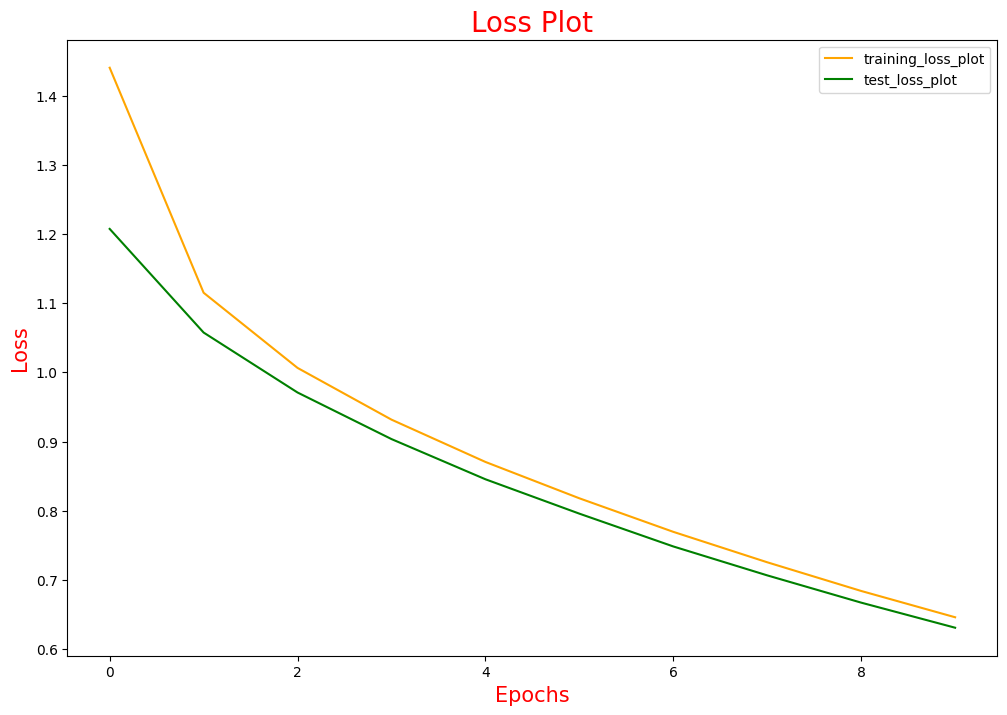

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8))
plt.plot(loss_plot, color='orange', label = 'training_loss_plot')
plt.plot(test_loss_plot, color='green', label = 'test_loss_plot')
plt.xlabel('Epochs', fontsize = 15, color = 'red')
plt.ylabel('Loss', fontsize = 15, color = 'red')
plt.title('Loss Plot', fontsize = 20, color = 'red')
plt.legend()
plt.show()


<h2>Model Evaluation</h2>
<ul>
<li><p>Define your evaluation function using greedy search</p></li>
<li><p>Define your evaluation function using beam search ( optional)</p></li>
<li><p>Test it on a sample data using BLEU score</p></li>
</ul>

<h2>Greedy Search</h2>
<ul>
 <li>This method is a simple approximation technique which calculates the probability of the words according to their occurrence in the English vocabulary.</li>

 <li>It takes the sample of the words, finds the probability of each of the words, and then outputs the word with the highest probability.</li>

 <li>Greedy Search will always consider only one best alternative and this makes the computational speed of the model fast, but the accuracy might not be up to the mark.</li>
    </ul>

In [ ]:
def evaluate(image):
    attention_plot = np.zeros((max_length, attention_feature_shape))

    hidden = decoder.init_state(batch_size=1)

    temp_input = tf.expand_dims(load_images(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    features = encoder (img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(max_length):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)
        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()
        result.append (tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


In [ ]:
def plot_attention_map (caption, weights, image) :

  fig = plt.figure(figsize = (20, 20))
  temp_img = np.array(Image.open(image))

  cap_len = len(caption)
  for cap in range(cap_len) :
    weights_img = np.reshape(weights[cap], (8,8))
    wweights_img = np.array(Image.fromarray(weights_img).resize((224,224), Image.LANCZOS))

    ax = fig.add_subplot(cap_len//2, cap_len//2, cap+1)
    ax.set_title(caption[cap], fontsize = 14, color = 'red')

    img = ax.imshow(temp_img)

    ax.imshow(weights_img, cmap='gist_heat', alpha=0.6, extent=img.get_extent())
    ax.axis('off')
  plt.subplots_adjust(hspace=0.2, wspace=0.2)
  plt.show()

In [ ]:
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
def filt_text(text):
    filt=['<start>','<unk>','<end>']
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

In [ ]:
image_test = path_test.copy()

In [ ]:
def pred_caption_audio(random, autoplay=False, weights=(0.5, 0.5, 0, 0)) :

    cap_test_data = caption_test.copy()
    rid = np.random.randint(0, random)
    test_image = image_test[rid]
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_test_data[rid] if i not in [0]])
    result, attention_plot, pred_test = evaluate(test_image)
    real_caption=filt_text(real_caption)
    pred_caption=' '.join(result).rsplit(' ', 1)[0]
    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = pred_caption.split()
    score = sentence_bleu(reference, candidate, weights=weights)#set your weights
    print(f"BLEU score: {score*100}")
    print ('Real Caption:', real_caption)
    print ('Prediction Caption:', pred_caption)
    plot_attention_map(result, attention_plot, test_image)
    speech = gTTS('Predicted Caption : ' + pred_caption, lang = 'en', slow = False)
    speech.save('voice.mp3')
    audio_file = 'voice.mp3'

    display.display(display.Audio(audio_file, rate = None, autoplay = autoplay))

    return test_image



 <h2> Test Images
</h2><ul>
  <li><p>BLEU is a well-acknowledged metric to measure similarity of one hypothesis sentence to multiple reference sentences. Given a single hypothesis sentence and multiple reference sentences, it returns a value between 0 and 1</p>
        </li>
  <li><p>The metric close to 1 means that the two are very similar.</p></li>
  <li>We use the BLEU measure to evaluate the result of the test set generated captions. The BLEU is simply taking the fraction of n-grams in the predicted sentence that appears in the ground-truth
</li>   
</ul>

In [ ]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.5, 0.25, 0, 0))
Image.open(test_image)

In [ ]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.5, 0.25, 0, 0))
Image.open(test_image)

In [ ]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.5, 0.25, 0, 0))
Image.open(test_image)

In [ ]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.5, 0.5, 0, 0))
Image.open(test_image)

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

BLEU score: 6.360494346864464e-153
Real Caption: basketball player in black jumps
Prediction Caption: two basketball players in white jersey is trying to block him


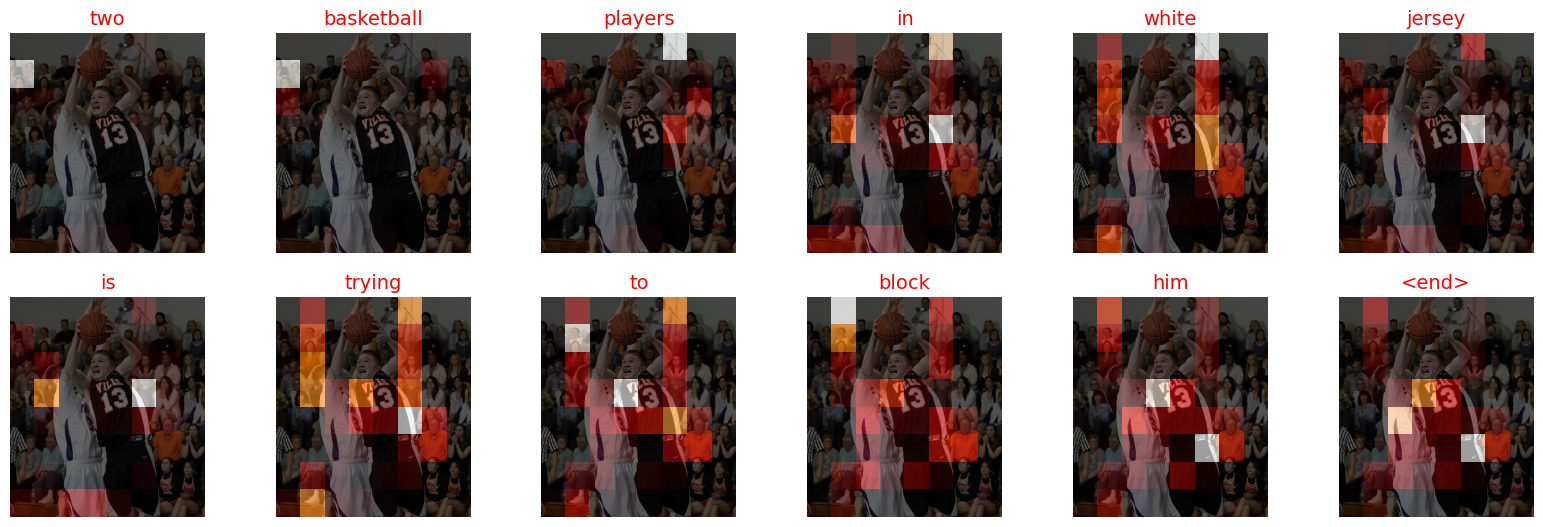

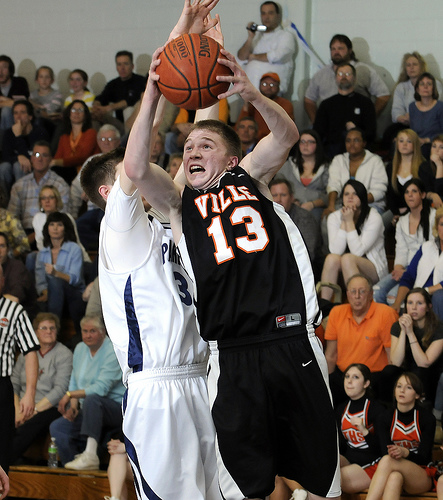

In [ ]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.5, 0.5, 0, 0))
Image.open(test_image)

BLEU score: 0
Real Caption: silver craft rides the waves
Prediction Caption: person is riding wave


ValueError: num must be an integer with 1 <= num <= 4, not 5

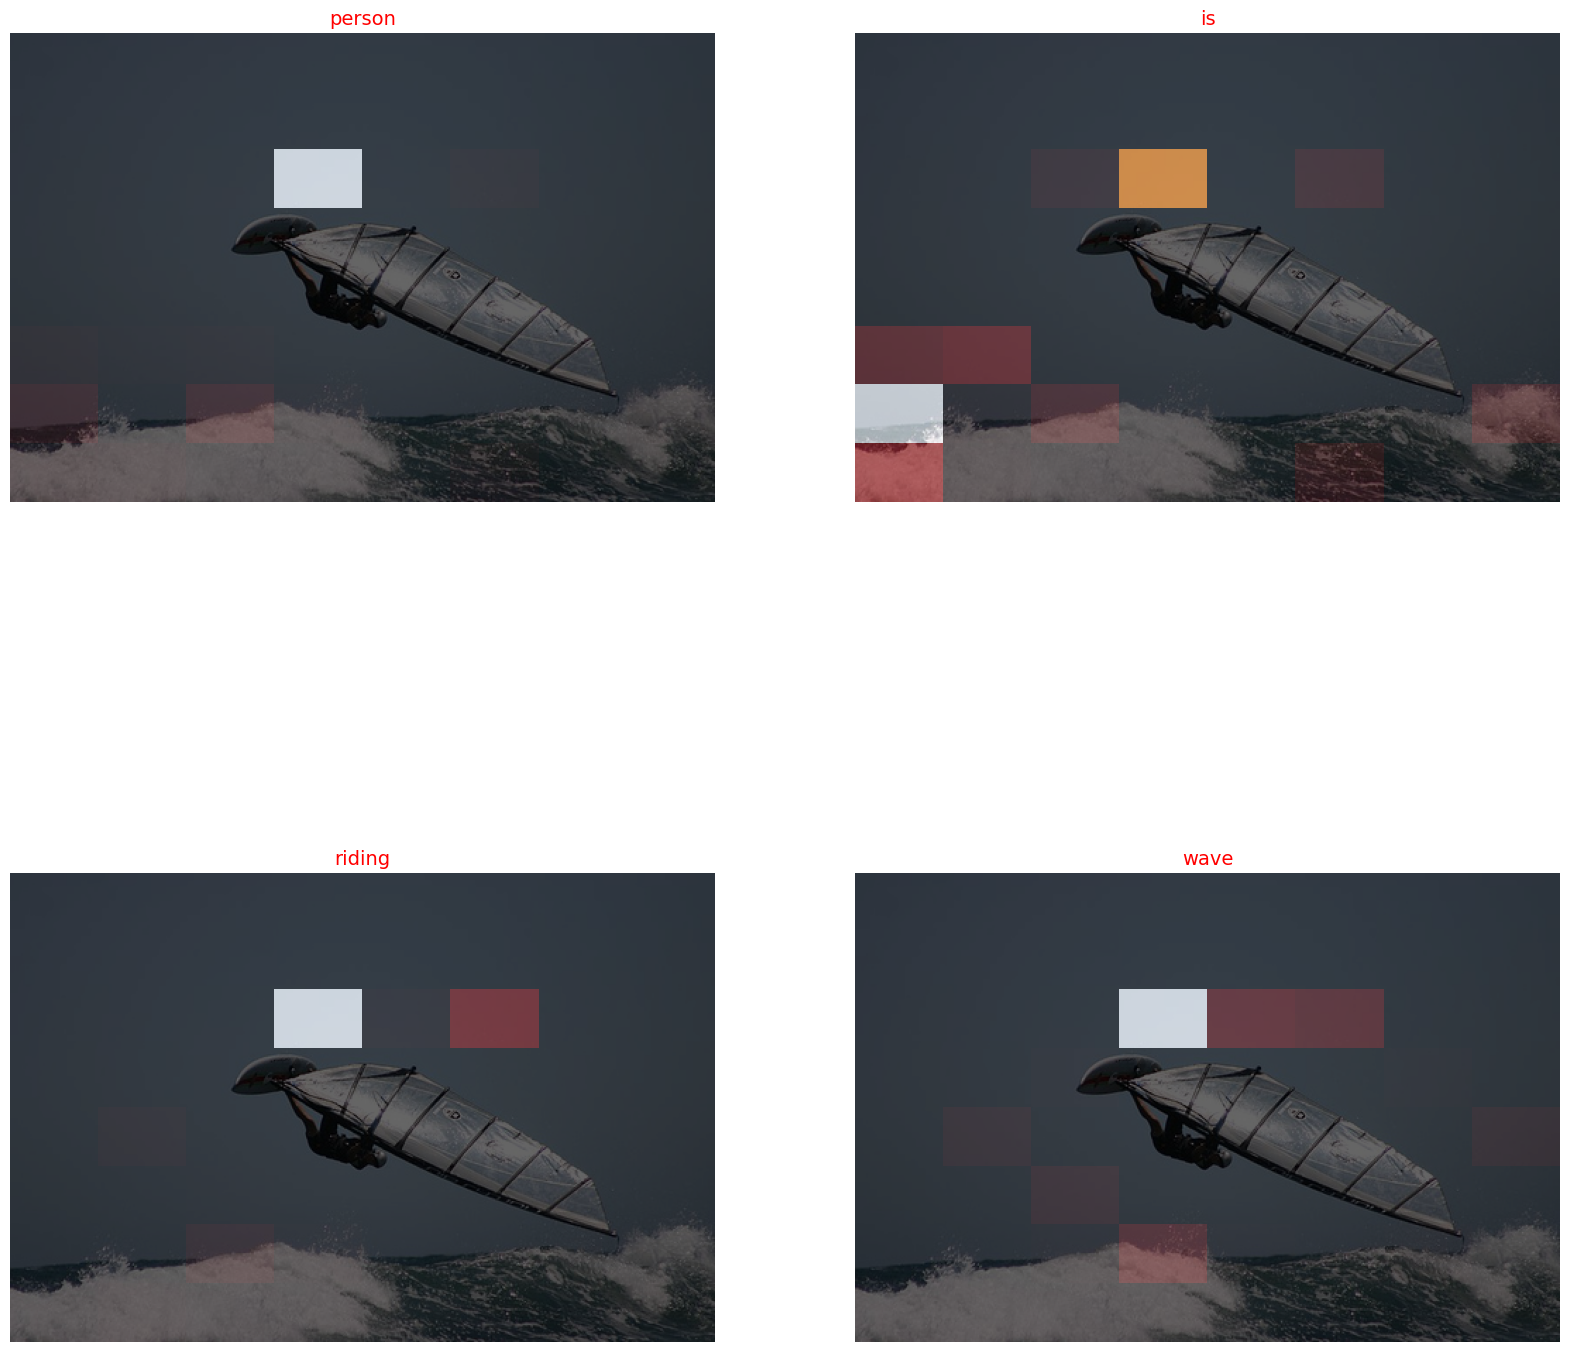

In [ ]:
test_image = pred_caption_audio(len(image_test), True, weights = (0.25, 0.25, 0, 0))
Image.open(test_image)

In [ ]:
encoder.save_weights('/content/drive/My Drive/DM Innovative/outputs_encoder')
decoder.save_weights('/content/drive/My Drive/DM Innovative/outputs_decoder')
